<a href="https://colab.research.google.com/github/yaelsh66/DL-course/blob/main/KNN_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install matplotlib pandas pillow


In [ ]:
!jupyter nbconvert --to html "knn_ann.ipynb"


[NbConvertApp] WARNING | pattern 'knn_ann.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Exe

Head of the DataFrame:
             Y            X      Scale       Angle  Response  Feature_1  \
0  1080.289917  1871.340576   2.650851  265.588531  0.108878      133.0   
1   992.686340  1960.387939   2.606995  353.797394  0.077875       30.0   
2  1958.299438  2614.439209  17.619907  261.920410  0.076401        2.0   
3  1485.067261  1269.294067   2.251461  267.496582  0.086173      129.0   
4  1375.478271  2610.739746   2.060762  218.360001  0.080922       70.0   

   Feature_2  Feature_3  Feature_4  Feature_5  ...  Feature_119  Feature_120  \
0       26.0        0.0        1.0        1.0  ...         28.0         25.0   
1       23.0       31.0        1.0        0.0  ...         71.0         84.0   
2        1.0        5.0       10.0        5.0  ...         28.0         61.0   
3       42.0        3.0       13.0       24.0  ...          9.0         41.0   
4      131.0        8.0       11.0        7.0  ...          6.0         13.0   

   Feature_121  Feature_122  Feature_123  Fea

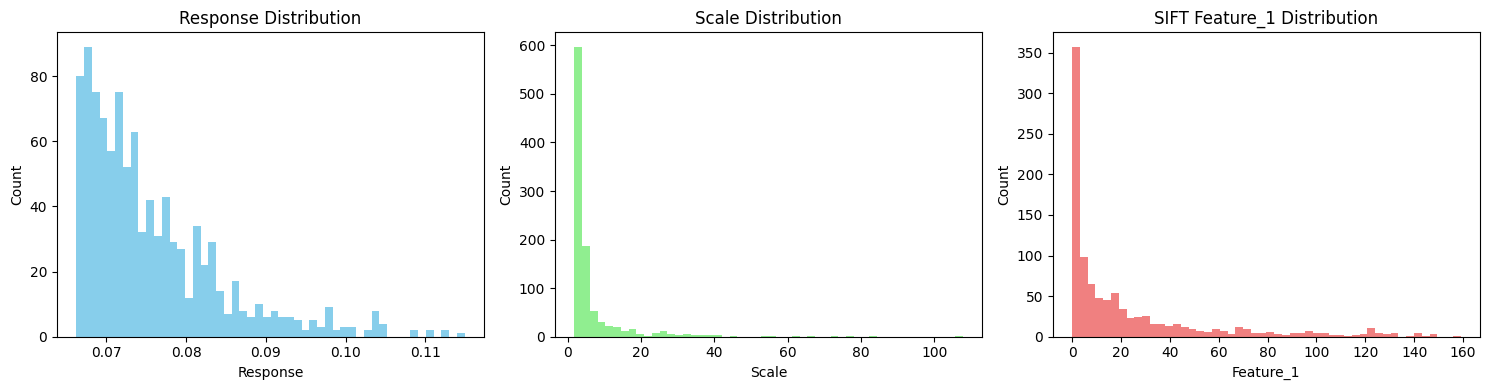

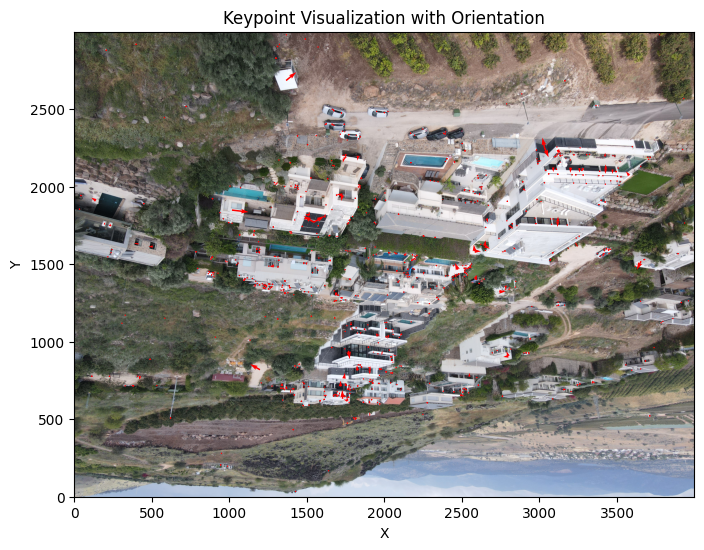

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

# === Load the SIFT dataset ===
df = pd.read_csv("migdal_1_sift_dataset.csv")

# === 1. Print basic info ===
print("Head of the DataFrame:")
print(df.head())

print("\nStatistical Summary:")
print(df.describe())

# === 2. Plot distribution of Response, Scale, and a few SIFT features ===
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df['Response'], bins=50, color='skyblue')
plt.title("Response Distribution")
plt.xlabel("Response")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
plt.hist(df['Scale'], bins=50, color='lightgreen')
plt.title("Scale Distribution")
plt.xlabel("Scale")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
plt.hist(df['Feature_1'], bins=50, color='lightcoral')
plt.title("SIFT Feature_1 Distribution")
plt.xlabel("Feature_1")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# === 3. Visualize Keypoints on the Image ===
# Load the corresponding image
img = Image.open("migdal_1.JPG")
img = np.array(img)

plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')

# Extract relevant columns
X = df['X']
Y = df['Y']
Scale = df['Scale']
Angle = df['Angle']

# Convert angles from degrees to radians
angles_rad = np.radians(Angle)

# Compute vector components for visualization (quiver)
u = np.cos(angles_rad) * Scale
v = np.sin(angles_rad) * Scale

plt.quiver(X, Y, u, v, angles='xy', scale_units='xy', scale=1, color='red')
plt.title("Keypoint Visualization with Orientation")
plt.gca().invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(False)
plt.show()


In [ ]:
def normalizeFeatures(features):
  norm = np.linalg.norm(features, axis=1, keepdims=True)
  normalized_features = features / (norm + 1e-8)
  return normalized_features

def distance(a, b):
  a_sq = np.sum(a**2, axis=1).reshape(1, -1)
  b_sq = np.sum(b**2, axis=1).reshape(-1, 1)
  dot = b @ a.T
  distance = b_sq + a_sq - 2 * dot
  return distance



In [ ]:
def knn(k, df_1, df_2):

  normalized_features_1 = normalizeFeatures(df_1.iloc[:, 5:133].values)
  normalized_features_2 = normalizeFeatures(df_2.iloc[:, 5:133].values)

  #Distance calculation
  dist = distance(normalized_features_1, normalized_features_2)

  #sort by distance
  indices = np.argsort(dist, axis=1)[:, :k]
  #Distance for k closest neibors
  distances = np.take_along_axis(dist, indices, axis=1)

  return indices, distances






In [ ]:
def siftKNN(threshold = 0.8):

  df_1 = pd.read_csv("migdal_1_sift_dataset.csv")
  df_2 = pd.read_csv("migdal_2_sift_dataset.csv")

  indices, distances = knn(2, df_1, df_2)

  ratios = distances[:, 0] / (distances[:, 1] + 1e-8)  # Add epsilon to avoid /0

  filtered_indices = indices.copy()

  # Go over all matches and apply the ratio test
  for i in range(len(ratios)):
    if ratios[i] >= threshold:
      # Reject match by setting index to -1 (no valid match)
      filtered_indices[i, 0] = -1

  visualizeSIFT(df_1, df_2, filtered_indices, distances, top_k=10)




In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

def visualizeSIFT(df_1, df_2, filtered_indices, distances, top_k=10):
    # Load the images
    img1 = Image.open("migdal_1.JPG").convert("RGB")
    img2 = Image.open("migdal_2.JPG").convert("RGB")

    # Combine images side by side
    w1, h1 = img1.size
    w2, h2 = img2.size
    combined_width = w1 + w2
    combined_height = max(h1, h2)

    combined_img = Image.new("RGB", (combined_width, combined_height))
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (w1, 0))

    draw = ImageDraw.Draw(combined_img)

    # Collect valid matches (indices and distances)
    matches = []
    for i in range(len(filtered_indices)):
        match_idx = filtered_indices[i, 0]
        if match_idx != -1:
            matches.append((i, match_idx, distances[i, 0]))

    # Sort matches by distance (lowest first) and take top_k
    matches.sort(key=lambda x: x[2])
    matches = matches[:top_k]

    # 🖨️ Print match info
    print(f"\nTop {top_k} matches:")
    for rank, (query_idx, train_idx, dist) in enumerate(matches):
        x1 = df_1.iloc[train_idx]["X"]
        y1 = df_1.iloc[train_idx]["Y"]
        x2 = df_2.iloc[query_idx]["X"]
        y2 = df_2.iloc[query_idx]["Y"]
        print(f"{rank + 1}. Distance: {dist:.4f}")
        print(f"    Image 1 (train): X={x1:.2f}, Y={y1:.2f}")
        print(f"    Image 2 (query): X={x2:.2f}, Y={y2:.2f}")

        # Draw the line
        draw.line([(x1, y1), (x2 + w1, y2)], fill="red", width=5)



    plt.figure(figsize=(12, 8))
    plt.imshow(combined_img)
    plt.axis("off")
    plt.title("Top 10 SIFT Matches (Passing Ratio Test)")
    plt.show()



Top 10 matches:
1. Distance: 0.0128
    Image 1 (train): X=1701.17, Y=653.17
    Image 2 (query): X=2086.57, Y=642.24
2. Distance: 0.0132
    Image 1 (train): X=1672.26, Y=649.94
    Image 2 (query): X=2055.79, Y=637.30
3. Distance: 0.0221
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1419.56, Y=1756.91
4. Distance: 0.0240
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1618.59, Y=1771.76
5. Distance: 0.0356
    Image 1 (train): X=1903.94, Y=610.04
    Image 2 (query): X=2352.27, Y=609.78
6. Distance: 0.0526
    Image 1 (train): X=3117.94, Y=1773.49
    Image 2 (query): X=2539.68, Y=1959.36
7. Distance: 0.0534
    Image 1 (train): X=3117.94, Y=1773.49
    Image 2 (query): X=2539.68, Y=1959.36
8. Distance: 0.0606
    Image 1 (train): X=1722.34, Y=2475.36
    Image 2 (query): X=754.44, Y=2226.83
9. Distance: 0.0606
    Image 1 (train): X=3422.58, Y=2194.62
    Image 2 (query): X=2561.03, Y=2483.68
10. Distance: 0.0619
    Image 1 (train): X=1479.83, Y

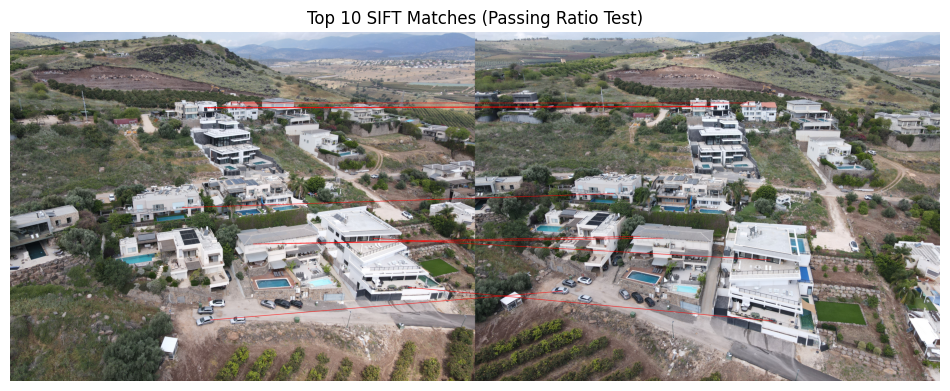

In [ ]:
siftKNN(threshold = 0.4)

In [ ]:
from abc import ABC, abstractmethod

class ANNBase(ABC):

  @abstractmethod
  def fit(self, data):
      """Train the model with data"""
      pass

  @abstractmethod
  def kneighbors(self, query, k=1):
      """Return k nearest neighbors for the given query"""
      pass



In [ ]:
from abc import ABC, abstractmethod
from collections import defaultdict

# TreeNode
class KDTreeNode:
  def __init__(self, axis=None, value=None, left=None, right=None, indices=None):
    self.axis = axis        # Dimension to split on
    self.value = value      # Split threshold (median value)
    self.left = left        # Left child node
    self.right = right      # Right child node
    self.indices = indices  # List of point indices (if leaf node)


class RKDT_ANN(ANNBase):
  def __init__(self, N0=10, L0=5):
    self.N0 = N0             # Max points per leaf
    self.L0 = L0             # Number of KD-Trees
    self.trees = []          # List of tree
    self.data = None         # Dataset

  def fit(self, data):

    self.data = data
    indices = np.arange(len(data))  # Index array for training samples
    self.trees = []
    # Build the trees
    for _ in range(self.L0):
      tree = self._build_tree(indices)
      self.trees.append(tree)

  def _build_tree(self, indices):

    if len(indices) <= self.N0:
      return KDTreeNode(indices=indices)  # Create leaf node

    # random dimension
    D = self.data.shape[1]
    axis = np.random.randint(0, D)

    # Compute median in that axis among current points
    values = self.data[indices, axis]
    median = np.median(values)

    # Split points into left and right branches
    left_indices = indices[values <= median]
    right_indices = indices[values > median]

    # Handle degenerate case (all values identical)
    if len(left_indices) == 0 or len(right_indices) == 0:
      return KDTreeNode(indices=indices)

    # Recursively build left and right subtrees
    left = self._build_tree(left_indices)
    right = self._build_tree(right_indices)

    return KDTreeNode(axis=axis, value=median, left=left, right=right)

  def kneighbors(self, query, k=1):

    # Check if single or multy query
    is_single_query = False
    if query.ndim == 1:
      query = query.reshape(1, -1)
      is_single_query = True

    all_indices = []
    all_distances = []

    for q in query:
      candidates = set()
      for tree in self.trees:
        self._search_tree(tree, q, candidates)

      candidate_list = list(candidates)
      candidate_vectors = self.data[candidate_list]

      dists = np.sum((candidate_vectors - q) ** 2, axis=1)
      nearest_idx = np.argsort(dists)[:k]

      all_indices.append(np.array(candidate_list)[nearest_idx])
      all_distances.append(dists[nearest_idx])

    indices = np.vstack(all_indices)
    distances = np.vstack(all_distances)

    if is_single_query:
      return indices[0], distances[0]
    return indices, distances

  def _search_tree(self, node, query, candidates):

    if node.indices is not None:
      candidates.update(node.indices)
      return

    axis = node.axis
    if query[axis] <= node.value:
      self._search_tree(node.left, query, candidates)
    else:
      self._search_tree(node.right, query, candidates)

In [ ]:
import numpy as np
from abc import ABC, abstractmethod
from collections import defaultdict

# Your base class
class ANNBase(ABC):
    @abstractmethod
    def fit(self, data):
        pass

    @abstractmethod
    def kneighbors(self, query, k=1):
        pass

# Tree node class
class KDTreeNode:
    def __init__(self, axis=None, value=None, left=None, right=None, indices=None):
        self.axis = axis
        self.value = value
        self.left = left
        self.right = right
        self.indices = indices  # Only used at leaf nodes

# RKDT_ANN implementation
class RKDT_ANN(ANNBase):
    def __init__(self, N0=10, L0=5):
        self.N0 = N0
        self.L0 = L0
        self.trees = []
        self.data = None

    def fit(self, data):
        self.data = data
        indices = np.arange(len(data))
        self.trees = [self._build_tree(indices) for _ in range(self.L0)]

    def _build_tree(self, indices):
        if len(indices) <= self.N0:
            return KDTreeNode(indices=indices)

        # Random split using a random SIFT point
        random_idx = np.random.choice(indices)
        random_point = self.data[random_idx]
        axis = np.argmax(random_point)  # choose dimension with highest value
        median = np.median(self.data[indices, axis])

        # Split points
        left_indices = indices[self.data[indices, axis] <= median]
        right_indices = indices[self.data[indices, axis] > median]

        # Fallback in degenerate cases
        if len(left_indices) == 0 or len(right_indices) == 0:
            return KDTreeNode(indices=indices)

        left = self._build_tree(left_indices)
        right = self._build_tree(right_indices)
        return KDTreeNode(axis=axis, value=median, left=left, right=right)

    def kneighbors(self, query, k=1):
        candidates = set()
        for tree in self.trees:
            self._search_tree(tree, query, candidates)

        # Get data points from candidates and compute distances
        candidate_list = list(candidates)
        candidate_vectors = self.data[candidate_list]

        dists = np.sum((candidate_vectors - query) ** 2, axis=1)
        sorted_indices = np.argsort(dists)[:k]
        return np.array(candidate_list)[sorted_indices], dists[sorted_indices]

    def _search_tree(self, node, query, candidates):
        # Leaf node: collect all point indices
        if node.indices is not None:
            candidates.update(node.indices)
            return

        # Go left or right based on query value and split
        axis = node.axis
        if query[axis] <= node.value:
            self._search_tree(node.left, query, candidates)
        else:
            self._search_tree(node.right, query, candidates)



Top 10 matches:
1. Distance: 0.0128
    Image 1 (train): X=1701.17, Y=653.17
    Image 2 (query): X=2086.57, Y=642.24
2. Distance: 0.0132
    Image 1 (train): X=1672.26, Y=649.94
    Image 2 (query): X=2055.79, Y=637.30
3. Distance: 0.0221
    Image 1 (train): X=2091.03, Y=1822.26
    Image 2 (query): X=1419.56, Y=1756.91
4. Distance: 0.0256
    Image 1 (train): X=1871.34, Y=1080.29
    Image 2 (query): X=2020.56, Y=1069.02
5. Distance: 0.0356
    Image 1 (train): X=1903.94, Y=610.04
    Image 2 (query): X=2352.27, Y=609.78
6. Distance: 0.0455
    Image 1 (train): X=1984.05, Y=926.87
    Image 2 (query): X=1803.07, Y=670.62
7. Distance: 0.0566
    Image 1 (train): X=2989.54, Y=2147.83
    Image 2 (query): X=957.41, Y=1652.31
8. Distance: 0.0582
    Image 1 (train): X=2109.48, Y=1047.48
    Image 2 (query): X=2172.10, Y=2435.11
9. Distance: 0.0606
    Image 1 (train): X=1722.34, Y=2475.36
    Image 2 (query): X=754.44, Y=2226.83
10. Distance: 0.0606
    Image 1 (train): X=3422.58, Y=21

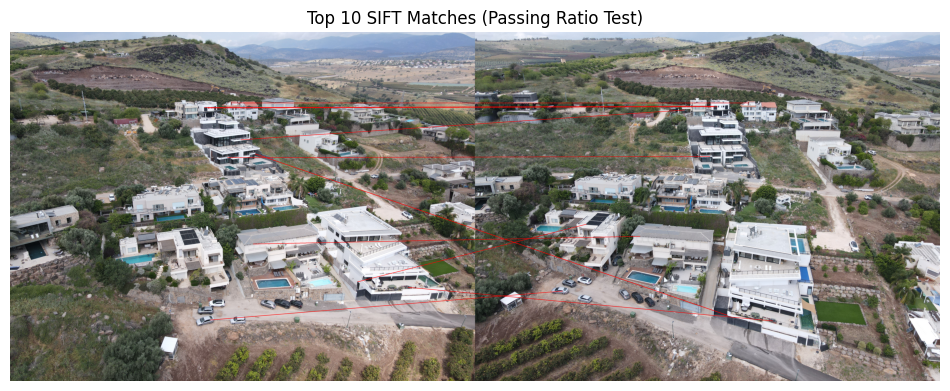

In [ ]:
def sift_rkdt():

    df_1 = pd.read_csv("migdal_1_sift_dataset.csv")
    df_2 = pd.read_csv("migdal_2_sift_dataset.csv")

    # Extract and normalize features (columns 5 to 132 inclusive = 128 dims)
    X_train = normalizeFeatures(df_1.iloc[:, 5:133].values)
    X_test = normalizeFeatures(df_2.iloc[:, 5:133].values)

    # Fit RKDT_ANN
    model = RKDT_ANN(N0=10, L0=5)
    model.fit(X_train)

    # Query all keypoints in df_2
    indices, distances = model.kneighbors(X_test, k=2)

    # ratio test
    ratios = distances[:, 0] / (distances[:, 1] + 1e-8)
    threshold = 0.6
    filtered_indices = indices.copy()
    for i in range(len(ratios)):
        if ratios[i] >= threshold:
            filtered_indices[i, 0] = -1  # Reject match

    # Visualize
    visualizeSIFT(df_1, df_2, filtered_indices, distances, top_k=10)

sift_rkdt()
